In [53]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import skimage
import math
import cmath

In [54]:
# A
frame_d20_A = cv2.imread("data/testimage_git/D20/_A.jpg")
frame_empty_A = cv2.imread("data/testimage_git/empty/_A.jpg")

# B
frame_d20_B = cv2.imread("data/testimage_git/D20/_B.jpg")
frame_empty_B = cv2.imread("data/testimage_git/empty/_B.jpg")

# C
frame_d20_C = cv2.imread("data/testimage_git/D20/_C.jpg")
frame_empty_C = cv2.imread("data/testimage_git/empty/_C.jpg")

In [55]:
def croppImageFrame(frame, resizeWidth, resizeHeight, croppedHeight):
    print("Readed Frame")
    readed_frame = plt.imshow(frame)
    plt.show(readed_frame)

    # resized image
    resizedFrame = cv2.resize(frame, (resizeWidth, resizeHeight))
    print("ResizedTestFrame")
    resizedTestFrame = plt.imshow(resizedFrame)
    plt.show(resizedTestFrame)

    # cropped image
    croppedFrame = resizedFrame[croppedHeight:resizeHeight, 0:resizeWidth]
    print("CroppedTestFrame")
    CroppedTestFrame = plt.imshow(croppedFrame)
    plt.show(CroppedTestFrame)

    return croppedFrame

In [56]:
def create_difference(beforeframe, afterframe, medianfilterkernelsize = 5):
    # Berechnung absolute Differenz zwischen den übergebenen Bildern
    diff = cv2.absdiff(beforeframe, afterframe)
    print("calculating difference")
    plt.show(plt.imshow(diff))
    print()

    # Umwandlung Farbformat von RGB nach Graustufen
    grayscale = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    print("converted img from rgb to gray")
    plt.show(plt.imshow(grayscale))
    print()

    # Bildglättung mit Medianfilter mit ksize-Filterfenstergröße
    blurred = cv2.medianBlur(grayscale, medianfilterkernelsize)
    print(f"geglättetes Bild mit Kernelgröße: {medianfilterkernelsize}")
    plt.show(plt.imshow(blurred))
    print()

    return blurred

In [57]:
def image_processing(blurred_diff_frame):
    # Canny Algorithm
    can = cv2.Canny(blurred_diff_frame, 30, 90)
    print("Canny Algorithm")
    plt.show(plt.imshow(can))

    print()

    # Return threshold value based on the triangle algorithm
    triangle_threshold = skimage.filters.threshold_triangle(blurred_diff_frame)
    print(f"triangle_threshold: {triangle_threshold}")
    _, triangle = cv2.threshold(blurred_diff_frame, triangle_threshold, 255, cv2.THRESH_BINARY)
    plt.show(plt.imshow(triangle))

    print()

    # Return threshold value based on Yen´s method
    yen_threshold = skimage.filters.threshold_yen(blurred_diff_frame)
    print(f"yen_threshold: {yen_threshold}")
    _, yen = cv2.threshold(blurred_diff_frame, yen_threshold, 255, cv2.THRESH_BINARY)
    plt.show(plt.imshow(yen))

    print()

    # Return threshold value based on Li´s iterative Minimum Cross Entropy method
    li_threshold = skimage.filters.threshold_li(blurred_diff_frame)
    print(f"li_threshold: {li_threshold}")
    _, li = cv2.threshold(blurred_diff_frame, li_threshold, 255, cv2.THRESH_BINARY)
    plt.show(plt.imshow(li))

    print()

    # Skalierung der Werte in einem Bild (auch hin zu Absolutwerten)
    combined_threshs = (triangle/3) + (yen/3) + (li/3)
    #own try: combined_threshs = triangle / 2 + yen / 2
    print(f"combined_thresh: {combined_threshs}" + "\n")
    combined_threshs = cv2.convertScaleAbs(combined_threshs)
    ret, all = cv2.threshold(combined_threshs, 150, 255, cv2.THRESH_BINARY)
    plt.show(plt.imshow(all))

    print()

    # Morphological operations to remove noise
    # kernels as ellipse with 3x5
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,5))
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,5))

    # Anwendung der erzeugten Kernel auf das combined_thresh img
    morphological_kernelOpen = cv2.morphologyEx(all, cv2.MORPH_OPEN, kernelOpen)
    print("Morphological kernel as ellipse 3x5 operations\nKernelOpen:")
    plt.show(plt.imshow(morphological_kernelOpen))

    morphological_kernelClose = cv2.morphologyEx(morphological_kernelOpen, cv2.MORPH_CLOSE, kernelClose)
    print("KernelClose:")
    plt.show(plt.imshow(morphological_kernelClose))
    img_preprocessed = morphological_kernelClose

    # Berechnung threshold & Anwendung Open/Close - Kernel auf geglättetes Bild vom Anfang
    # mithilfe des übergebenen Parameters "thresh_val"
    thresh_val = 15
    print(f"eingegangenes geglättetes Bild")
    plt.show(plt.imshow(blurred_diff_frame))

    _, thresh = cv2.threshold(blurred_diff_frame, thresh_val, 255, cv2.THRESH_BINARY)
    print("Anwendung threshold..")
    plt.show(plt.imshow(thresh))

    print()

    # Anwendung Open Kernel
    thresh_morph_kernelOpen = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernelOpen)
    print("Anwendung Kernel Open")
    plt.show(plt.imshow(thresh_morph_kernelOpen))

    print()

    # Anwendung Close Kernel
    thresh_morph_kernelClose = cv2.morphologyEx(thresh_morph_kernelOpen, cv2.MORPH_CLOSE, kernelClose)
    print("Anwendung Kernel Close")
    plt.show(plt.imshow(thresh_morph_kernelClose))

    print()

    # Combine thresholded image with Canny edge detector
    final = img_preprocessed | can
    #plt.show(plt.imshow(final))

    print("Returns")
    # Returns:
    print("final")
    plt.show(plt.imshow(final))
    print("thresh")
    plt.show(plt.imshow(thresh_morph_kernelClose))

    return final, thresh_morph_kernelClose

In [58]:
def find_dart_tip(processedImage):
    contours, hierarchy = cv2.findContours(processedImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    returnvalue = 0
    contourLength = len(contours)
    print(f"FindingDartTip:\nAnzahl detektierte Konturen = {contourLength}")
    if contourLength == 0:
        returnvalue = 0
    else:
        contoursSorted = sorted(contours, key = cv2.contourArea, reverse= True)
        contournumber = 0
        for contour in contoursSorted:
            contournumber += 1
            print(f"\nKontur: {contournumber}") 
            size = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)

            if size > 10000:
                returnvalue = "Hand"
                print("Hand")
                break
            elif size < 50:
                print(f"size [{size}] < 50")
                continue
            elif h < w:
                print(f"h [{h}] < w [{w}]")
                continue
            else:
                potential = tuple(contour[contour[:, :, 1].argmax()][0])
                thresh_for_high_y_coordinate = potential[1] - 2
                all_high_y_coordinates = contour[contour[:,:,1] >= thresh_for_high_y_coordinate]
                potential_all_mean = np.mean(all_high_y_coordinates, axis = 0)
                potential_all_mean = tuple(np.rint(potential_all_mean).astype(int))

                print(f"mean potential: {potential_all_mean}")

                contourimage = processedImage.copy()
                cv2.rectangle(contourimage, (x,y), (x+w, y+h), (255,255,255), 1)
                plt.show(plt.imshow(contourimage))
                
                cv2.line(contourimage, (0, potential_all_mean[1]), (contourimage.shape[1], potential_all_mean[1]),  color=(255, 255, 255), thickness=1)
                cv2.line(contourimage, (potential_all_mean[0], 0), (potential_all_mean[0], contourimage.shape[0]),  color=(255, 255, 255), thickness=1)
                plt.show(plt.imshow(contourimage))

                if returnvalue != 0:
                    if returnvalue[1] < potential[1]:
                        returnvalue = potential
                        print("set val to new potential")
                else:
                    returnvalue = potential
                    print("set val to new potential")

    if returnvalue != 0 and returnvalue != "Hand":
        print("Result of Find Dart Tip:")
        plt.show(plt.imshow(processedImage))
        processedLineImage = processedImage.copy()
        cv2.line(processedLineImage, (0, returnvalue[1]), (processedLineImage.shape[1], returnvalue[1]),  color=(255, 255, 255), thickness=1)
        cv2.line(processedLineImage, (returnvalue[0], 0), (returnvalue[0], processedLineImage.shape[0]),  color=(255, 255, 255), thickness=1)
        plt.show(plt.imshow(processedLineImage))

    return returnvalue

In [59]:
def find_angle(xPos, width, fov):
    # Returns the angle between the detected point and the center of the image
    x = xPos - width/2

    angle = math.atan((2*x*math.tan(math.radians(fov/2)))/(width))
    angle = math.degrees(angle)
    
    print(f"Angle: {angle}")

    return angle

In [60]:
def get_angle_in_gradient_a(processedDartTip, resizeWidth, fov):
    angle = find_angle(processedDartTip[0], resizeWidth, fov) - find_angle(320, 640, fov) - 27

    print(f"adjusted Angle {angle}")

    # angle_to_gradient
    if angle == 0:
        slope = 0
    if angle < 0:
        slope = 1
    if angle > 0:
        slope = -1

    angle = abs(angle)

    gradient = math.sin(math.radians(angle)) / math.cos(math.radians(angle))
    gradient *= slope

    print(f"Gradient: {gradient}")

    return gradient

In [61]:
def get_angle_in_gradient_b(processedDartTip, resizeWidth, fov):
    angle = find_angle(processedDartTip[0], resizeWidth, fov) - find_angle(320, 640, fov) + 27

    print(f"adjusted Angle {angle}")

    # angle_to_gradient
    if angle == 0:
        slope = 0
    if angle < 0:
        slope = 1
    if angle > 0:
        slope = -1

    angle = abs(angle)

    gradient = math.sin(math.radians(angle)) / math.cos(math.radians(angle))
    gradient *= slope

    print(f"Gradient: {gradient}")

    return gradient

In [62]:
def get_angle_in_gradient_c(processedDartTip, resizeWidth, fov):
    angle = find_angle(processedDartTip[0], resizeWidth, fov) - find_angle(320, 640, fov) + 9

    print(f"adjusted Angle {angle}")

    # angle_to_gradient
    if angle == 0:
        slope = 0
    if angle < 0:
        slope = 1
    if angle > 0:
        slope = -1

    angle = abs(angle)

    gradient = math.sin(math.radians(angle)) / math.cos(math.radians(angle))
    gradient *= slope

    gradient = -(1/gradient)

    print(f"Gradient: {gradient}")

    return gradient

In [63]:
def score_detection(emptyframe, testframe, imageposition, medianfilterkernelsize = 5, tip_finalprocessedimage = True):
    fov = 67.1
        
    height, width, _ = frame_d20_A.shape
    print(f"basic height: {height},\nbasic width: {width}")
    print()
    
    # test with resized size
    resizeHeight = int(height/1.5)
    resizeWidth = int(width/1.5)
    croppedHeight = int(2*resizeHeight/5)

    # test with no resized size
    #resizeHeight = int(height)
    #resizeWidth = int(width)
    #croppedHeight = 0

    print(f"Resized shape:\nresized height: {resizeHeight},\nresized width: {resizeWidth},\ncropped height: {croppedHeight}\n")

    print("empty frame")
    cropped_empty = croppImageFrame(emptyframe, resizeWidth, resizeHeight, croppedHeight)
    print("test frame")
    cropped_d20 = croppImageFrame(testframe, resizeWidth, resizeHeight, croppedHeight)
    

    print(f"create difference with medianfilterkernelsize: {medianfilterkernelsize}")
    blurred_ksize = create_difference(cropped_empty, cropped_d20, medianfilterkernelsize)

    print("image processing")
    final_ksize, thresh_ksize = image_processing(blurred_ksize)

    print("find dart tip Gradient - final image")
    tipfinal_ksize = find_dart_tip(final_ksize)

    print("find dart tip Gradient - thresh image")
    tipthresh_ksize = find_dart_tip(thresh_ksize)

    gradient = 0

    if tip_finalprocessedimage:
        gradient_image = tipfinal_ksize
    else:
        gradient_image = tipthresh_ksize
    

    if imageposition == "A":
        gradient = get_angle_in_gradient_a(gradient_image, resizeWidth, fov)
        #gradient = get_angle_in_gradient_a([188.46], resizeWidth, fov) # Test with manually measured x Pos = 188.46
    elif imageposition == "B":
        gradient = get_angle_in_gradient_b(gradient_image, resizeWidth, fov)
        #gradient = get_angle_in_gradient_b([192.3], resizeWidth, fov) # Test with manually measured x Pos = 192.3
    elif imageposition == "C":
        gradient = get_angle_in_gradient_c(gradient_image, resizeWidth, fov)
        #gradient = get_angle_in_gradient_c([407.69], resizeWidth, fov) # Test with manually measured x Pos = 407.69

        
    return gradient

basic height: 480,
basic width: 640

Resized shape:
resized height: 320,
resized width: 426,
cropped height: 128

empty frame
Readed Frame


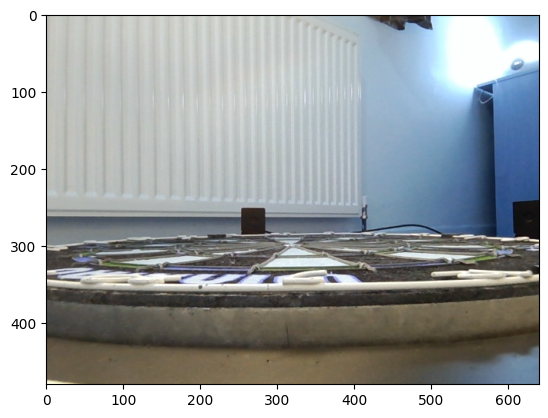

ResizedTestFrame


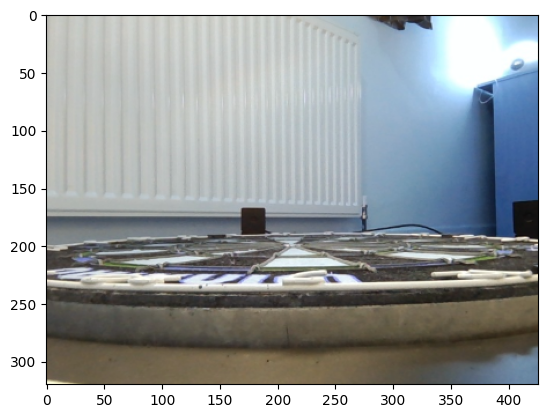

CroppedTestFrame


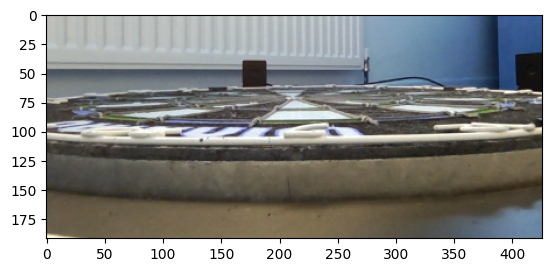

test frame
Readed Frame


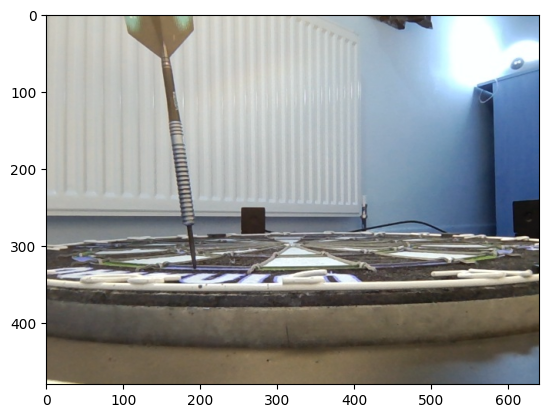

ResizedTestFrame


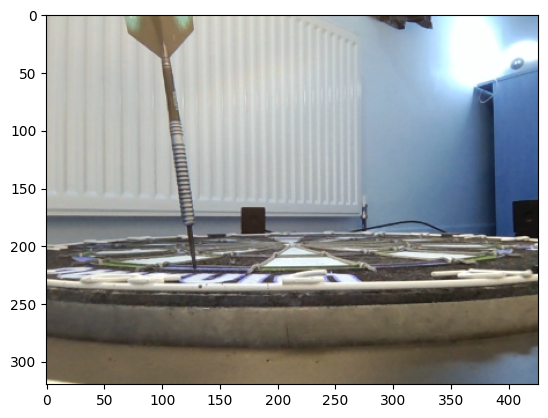

CroppedTestFrame


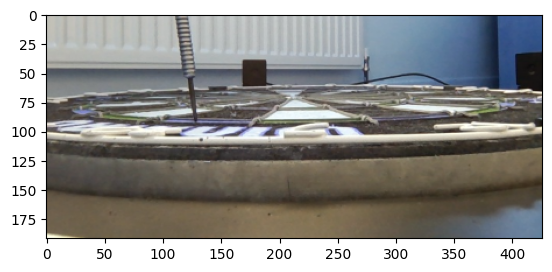

create difference with medianfilterkernelsize: 5
calculating difference


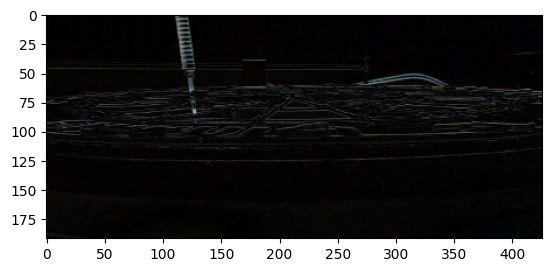


converted img from rgb to gray


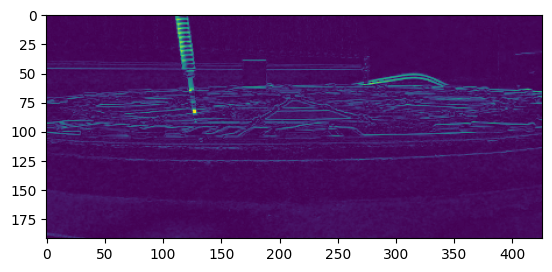


geglättetes Bild mit Kernelgröße: 5


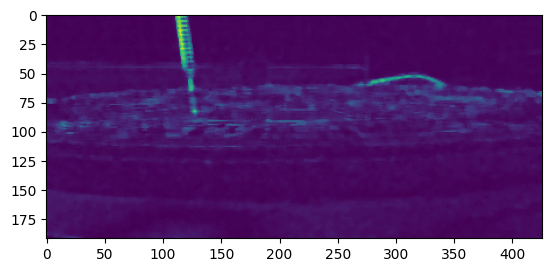


image processing
Canny Algorithm


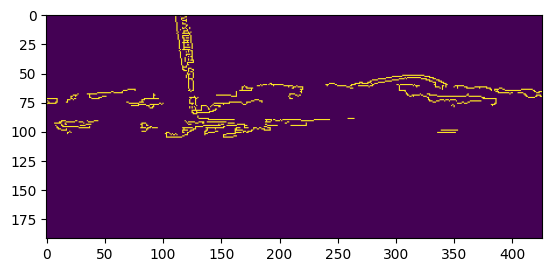


triangle_threshold: 12


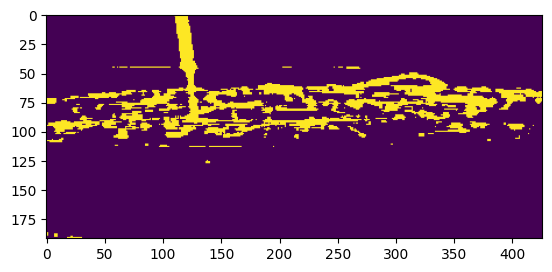


yen_threshold: 36


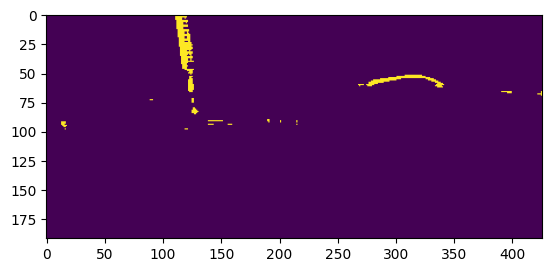


li_threshold: 7.980647318824708


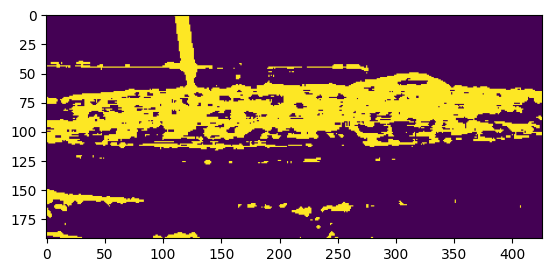


combined_thresh: [[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [170. 170.  85. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]



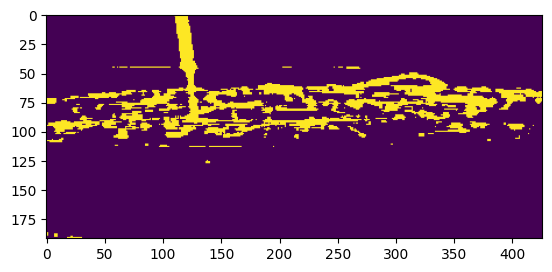


Morphological kernel as ellipse 3x5 operations
KernelOpen:


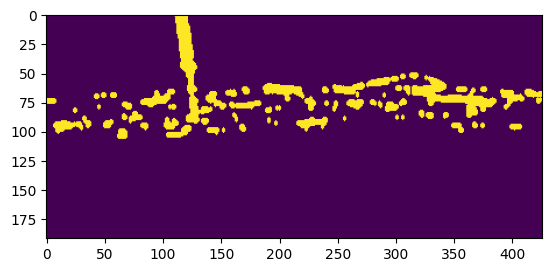

KernelClose:


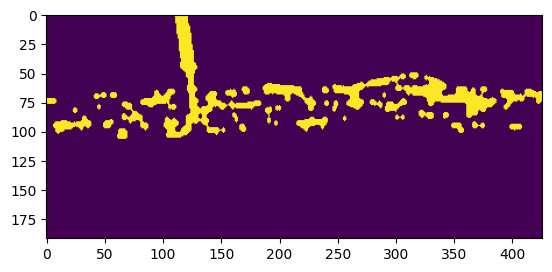

eingegangenes geglättetes Bild


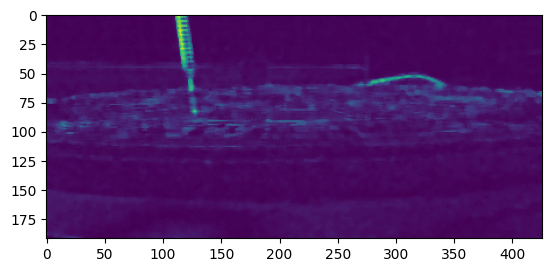

Anwendung threshold..


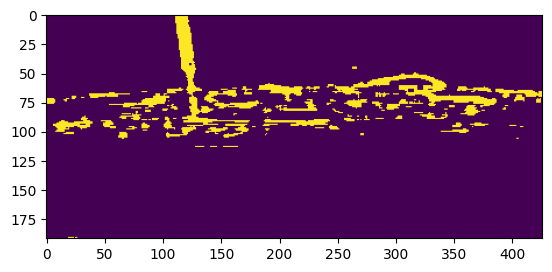


Anwendung Kernel Open


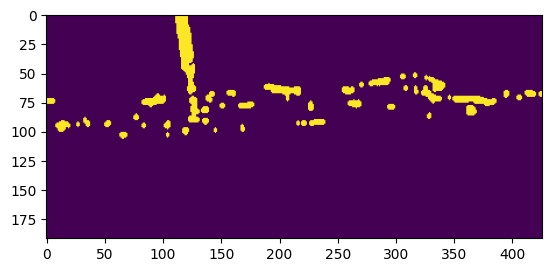


Anwendung Kernel Close


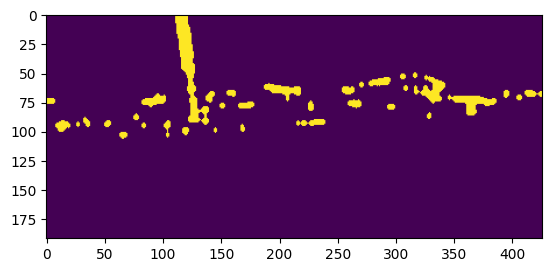


Returns
final


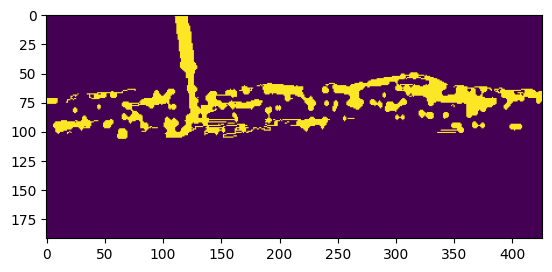

thresh


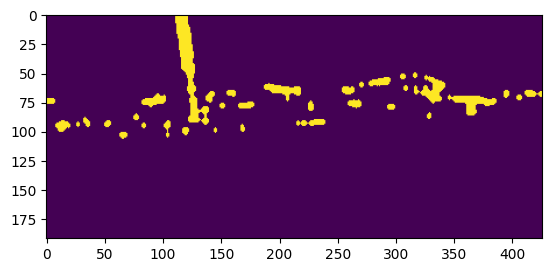

find dart tip Gradient - final image
FindingDartTip:
Anzahl detektierte Konturen = 65

Kontur: 1
h [39] < w [150]

Kontur: 2
mean potential: (np.int64(120), np.int64(104))


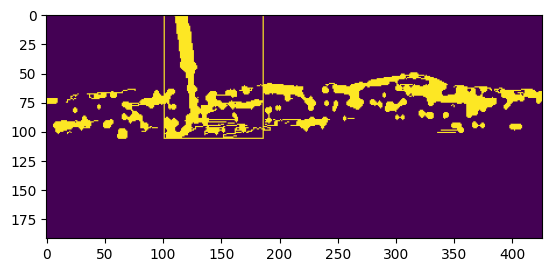

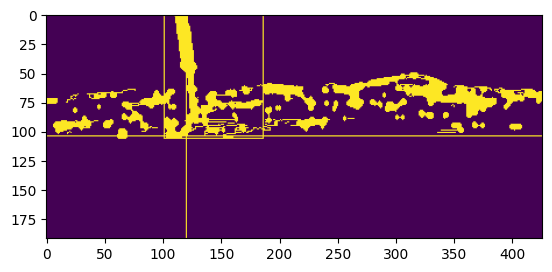

set val to new potential

Kontur: 3
h [37] < w [47]

Kontur: 4
h [24] < w [51]

Kontur: 5
h [19] < w [41]

Kontur: 6
h [18] < w [92]

Kontur: 7
h [16] < w [39]

Kontur: 8
h [9] < w [29]

Kontur: 9
h [12] < w [19]

Kontur: 10
h [9] < w [42]

Kontur: 11
mean potential: (np.int64(65), np.int64(106))


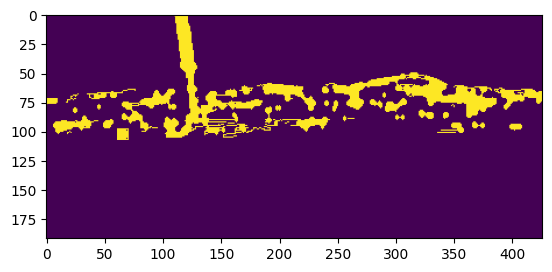

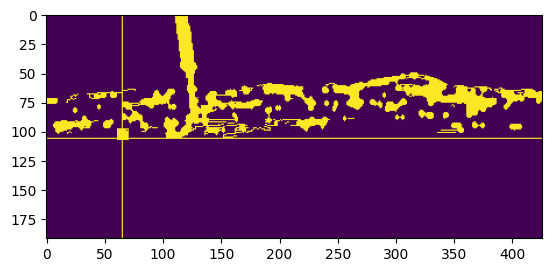

set val to new potential

Kontur: 12
h [8] < w [13]

Kontur: 13
size [49.0] < 50

Kontur: 14
size [41.0] < 50

Kontur: 15
size [41.0] < 50

Kontur: 16
size [39.5] < 50

Kontur: 17
size [39.0] < 50

Kontur: 18
size [37.5] < 50

Kontur: 19
size [36.0] < 50

Kontur: 20
size [35.5] < 50

Kontur: 21
size [34.5] < 50

Kontur: 22
size [32.5] < 50

Kontur: 23
size [28.5] < 50

Kontur: 24
size [22.5] < 50

Kontur: 25
size [15.5] < 50

Kontur: 26
size [15.0] < 50

Kontur: 27
size [14.0] < 50

Kontur: 28
size [13.5] < 50

Kontur: 29
size [12.5] < 50

Kontur: 30
size [12.0] < 50

Kontur: 31
size [11.0] < 50

Kontur: 32
size [10.0] < 50

Kontur: 33
size [10.0] < 50

Kontur: 34
size [10.0] < 50

Kontur: 35
size [10.0] < 50

Kontur: 36
size [8.5] < 50

Kontur: 37
size [7.5] < 50

Kontur: 38
size [7.0] < 50

Kontur: 39
size [7.0] < 50

Kontur: 40
size [6.0] < 50

Kontur: 41
size [6.0] < 50

Kontur: 42
size [6.0] < 50

Kontur: 43
size [5.5] < 50

Kontur: 44
size [5.5] < 50

Kontur: 45
size [4.0] < 50



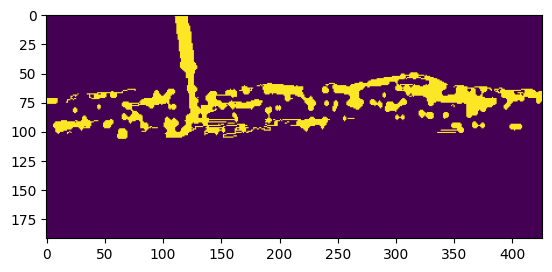

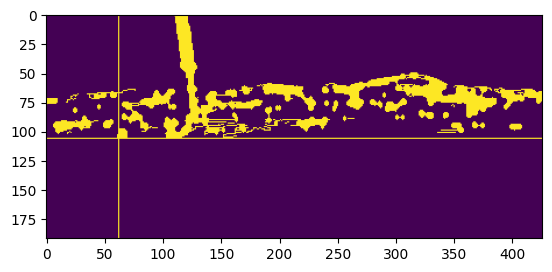

find dart tip Gradient - thresh image
FindingDartTip:
Anzahl detektierte Konturen = 36

Kontur: 1
mean potential: (np.int64(133), np.int64(93))


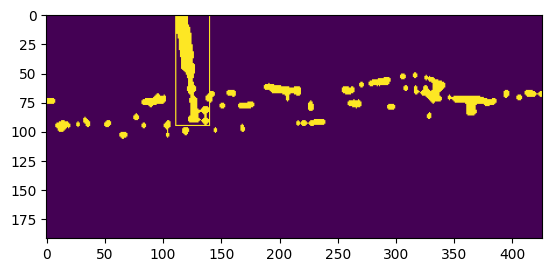

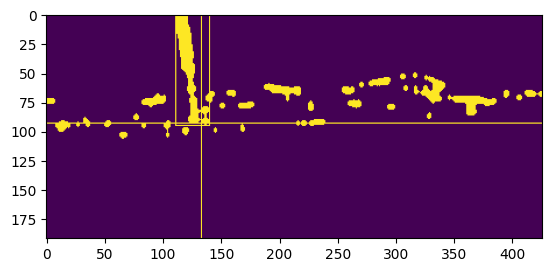

set val to new potential

Kontur: 2
h [18] < w [42]

Kontur: 3
h [25] < w [27]

Kontur: 4
h [16] < w [32]

Kontur: 5
h [12] < w [21]

Kontur: 6
h [8] < w [19]

Kontur: 7
h [6] < w [25]

Kontur: 8
h [10] < w [13]

Kontur: 9
h [6] < w [14]

Kontur: 10
h [8] < w [12]

Kontur: 11
h [7] < w [11]

Kontur: 12
size [48.0] < 50

Kontur: 13
size [41.0] < 50

Kontur: 14
size [32.5] < 50

Kontur: 15
size [32.5] < 50

Kontur: 16
size [28.5] < 50

Kontur: 17
size [27.0] < 50

Kontur: 18
size [26.0] < 50

Kontur: 19
size [24.5] < 50

Kontur: 20
size [24.0] < 50

Kontur: 21
size [24.0] < 50

Kontur: 22
size [22.0] < 50

Kontur: 23
size [20.5] < 50

Kontur: 24
size [20.0] < 50

Kontur: 25
size [15.0] < 50

Kontur: 26
size [14.0] < 50

Kontur: 27
size [14.0] < 50

Kontur: 28
size [14.0] < 50

Kontur: 29
size [13.5] < 50

Kontur: 30
size [11.5] < 50

Kontur: 31
size [10.0] < 50

Kontur: 32
size [10.0] < 50

Kontur: 33
size [10.0] < 50

Kontur: 34
size [10.0] < 50

Kontur: 35
size [6.0] < 50

Kontur: 36
s

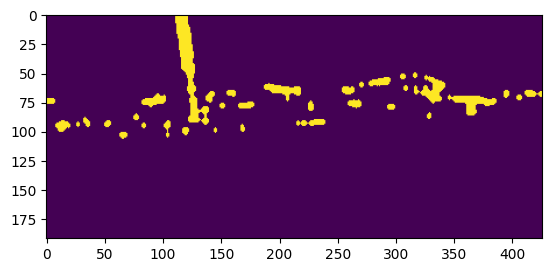

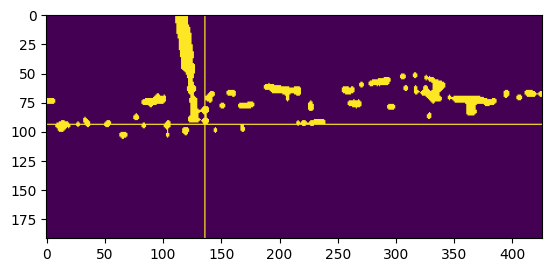

Angle: -25.178884818347708
Angle: 0.0
adjusted Angle -52.17888481834771
Gradient: 1.2882116661165837


In [64]:
aGrad = score_detection(frame_empty_A, frame_d20_A, "A", 5, True)

basic height: 480,
basic width: 640

Resized shape:
resized height: 320,
resized width: 426,
cropped height: 128

empty frame
Readed Frame


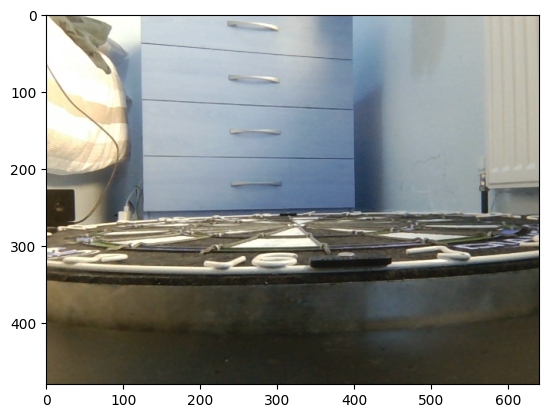

ResizedTestFrame


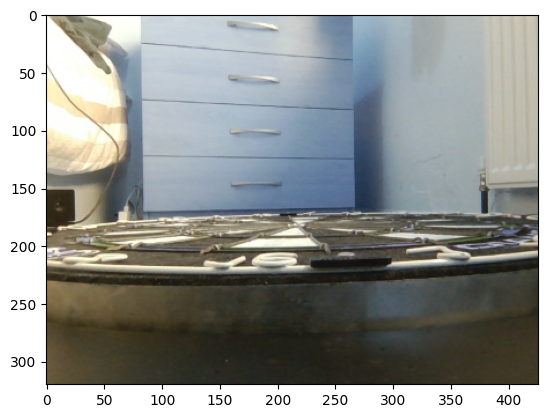

CroppedTestFrame


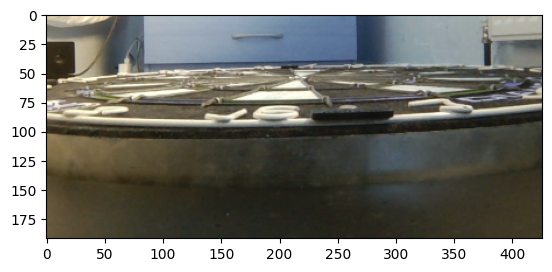

test frame
Readed Frame


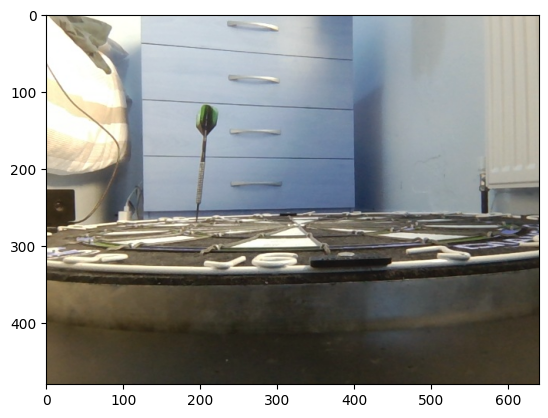

ResizedTestFrame


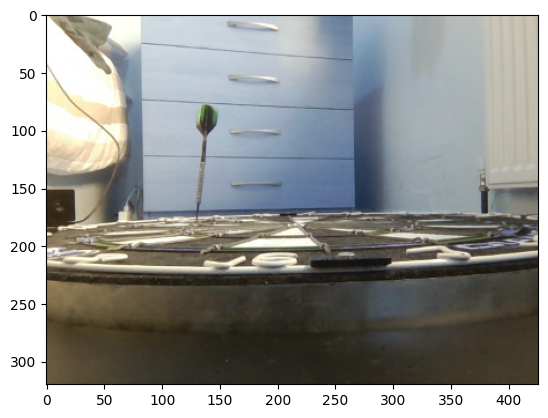

CroppedTestFrame


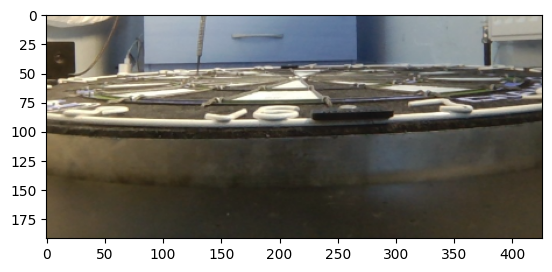

create difference with medianfilterkernelsize: 5
calculating difference


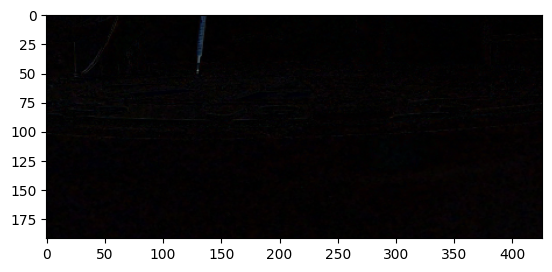


converted img from rgb to gray


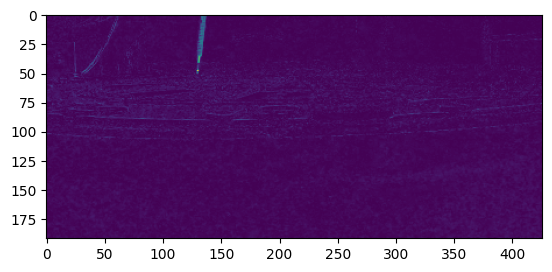


geglättetes Bild mit Kernelgröße: 5


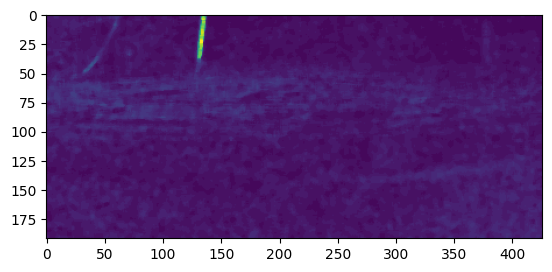


image processing
Canny Algorithm


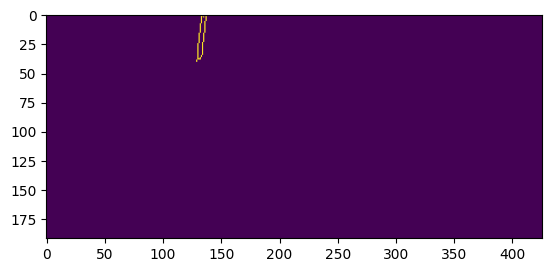


triangle_threshold: 7


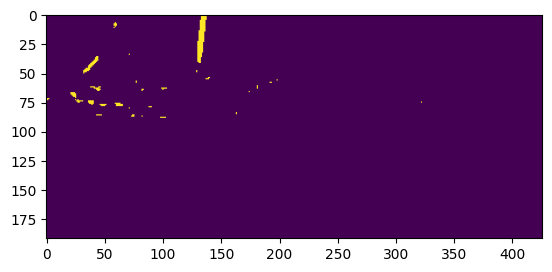


yen_threshold: 10


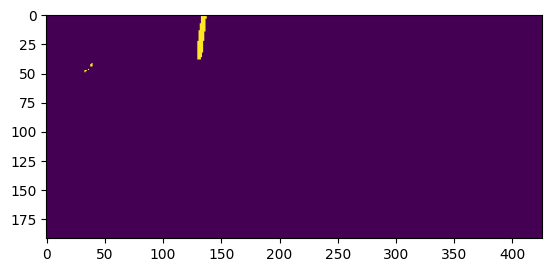


li_threshold: 2.6811892146567273


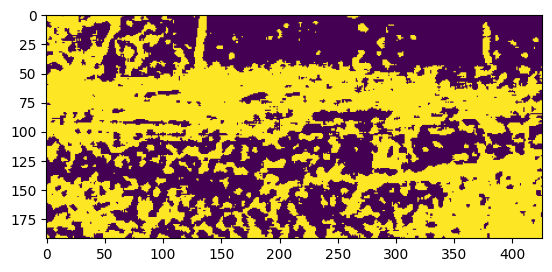


combined_thresh: [[85. 85. 85. ...  0.  0.  0.]
 [85. 85. 85. ...  0.  0.  0.]
 [85. 85. 85. ...  0.  0.  0.]
 ...
 [85. 85.  0. ... 85. 85. 85.]
 [85. 85. 85. ... 85. 85. 85.]
 [85. 85. 85. ... 85. 85. 85.]]



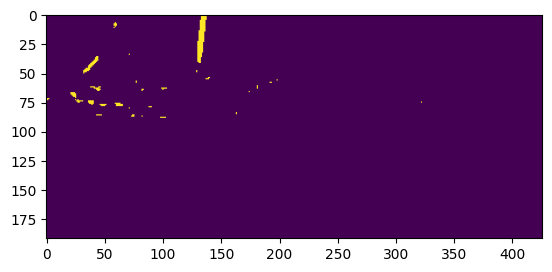


Morphological kernel as ellipse 3x5 operations
KernelOpen:


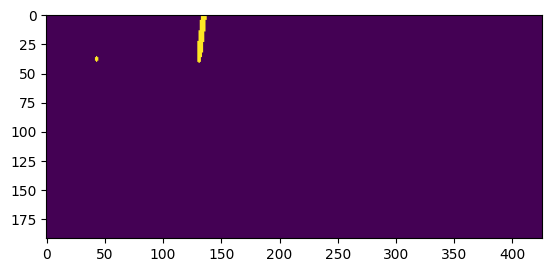

KernelClose:


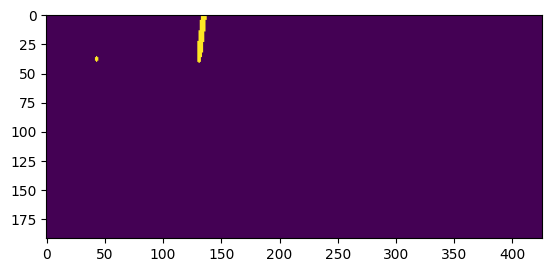

eingegangenes geglättetes Bild


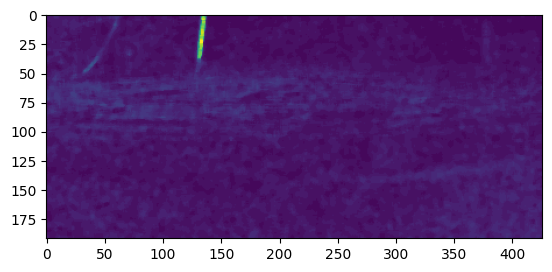

Anwendung threshold..


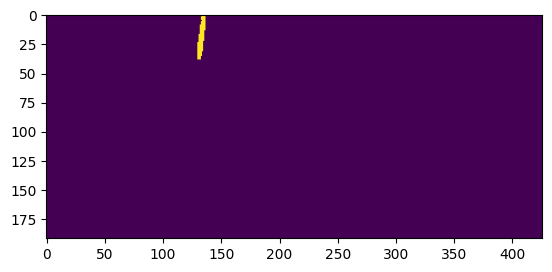


Anwendung Kernel Open


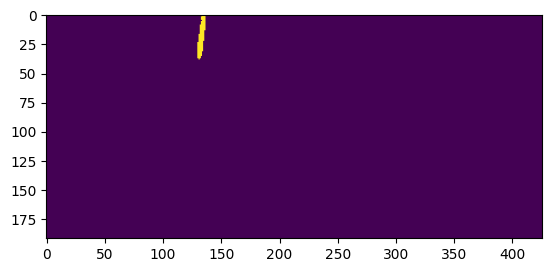


Anwendung Kernel Close


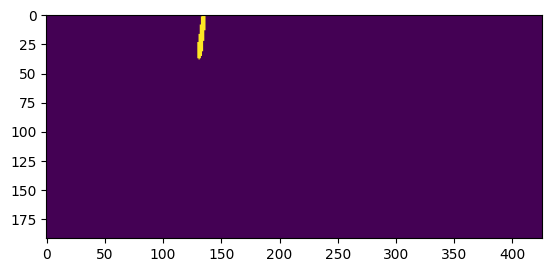


Returns
final


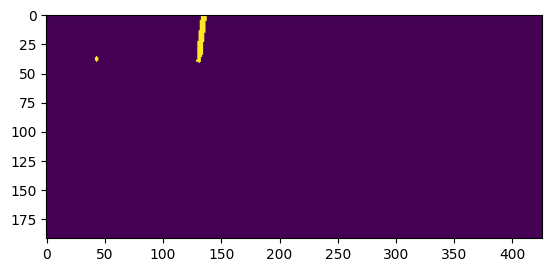

thresh


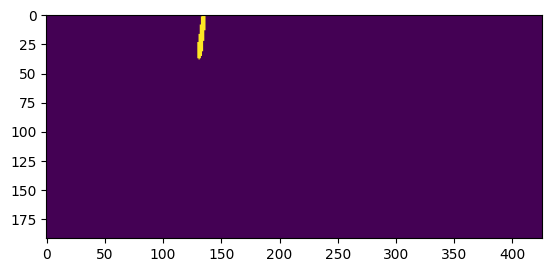

find dart tip Gradient - final image
FindingDartTip:
Anzahl detektierte Konturen = 2

Kontur: 1
mean potential: (np.int64(130), np.int64(40))


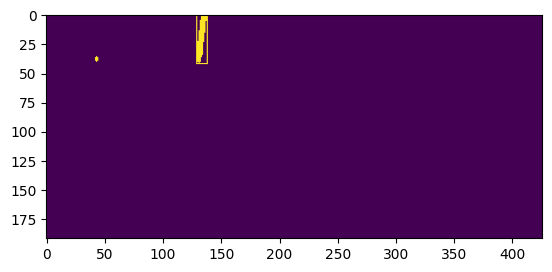

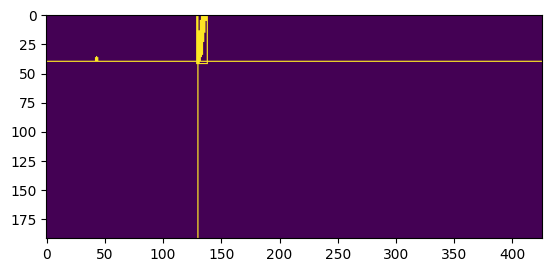

set val to new potential

Kontur: 2
size [6.0] < 50
Result of Find Dart Tip:


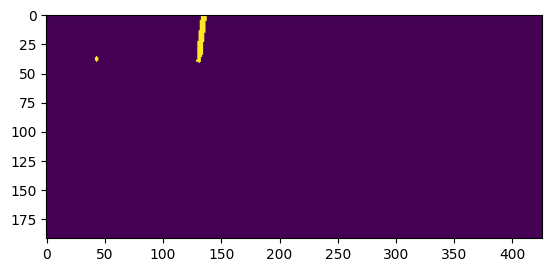

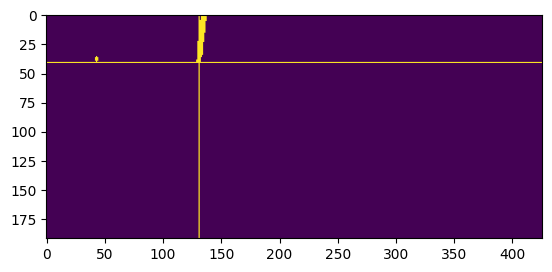

find dart tip Gradient - thresh image
FindingDartTip:
Anzahl detektierte Konturen = 1

Kontur: 1
mean potential: (np.int64(131), np.int64(37))


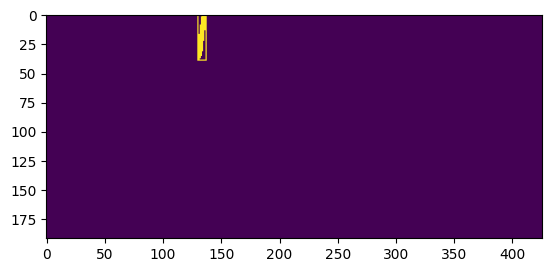

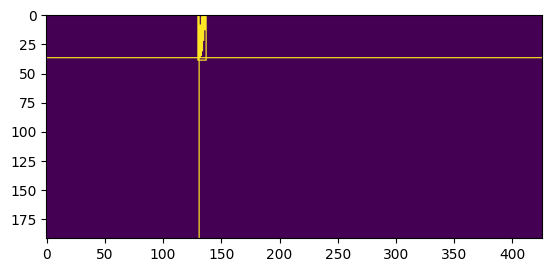

set val to new potential
Result of Find Dart Tip:


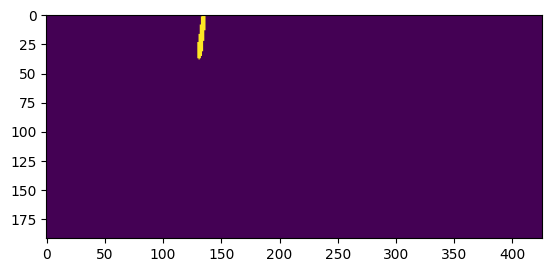

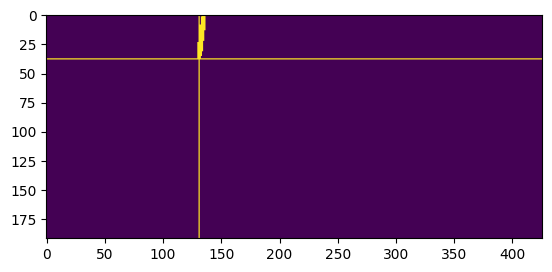

Angle: -14.321357441364448
Angle: 0.0
adjusted Angle 12.678642558635552
Gradient: -0.22496807696067228


In [65]:
bGrad = score_detection(frame_empty_B, frame_d20_B, "B", 5, True)

basic height: 480,
basic width: 640

Resized shape:
resized height: 320,
resized width: 426,
cropped height: 128

empty frame
Readed Frame


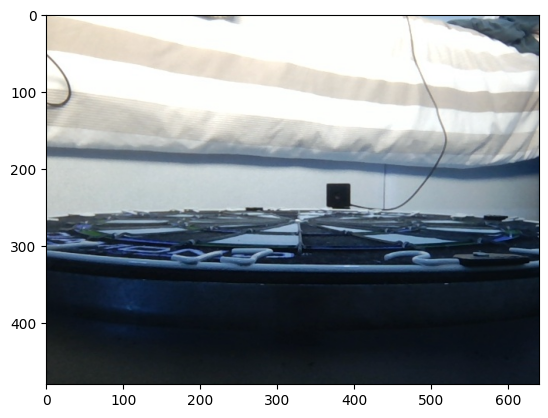

ResizedTestFrame


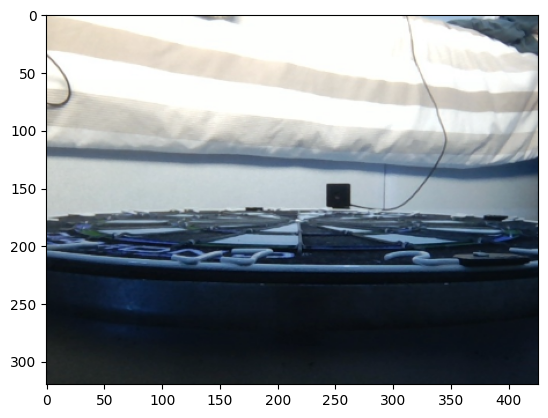

CroppedTestFrame


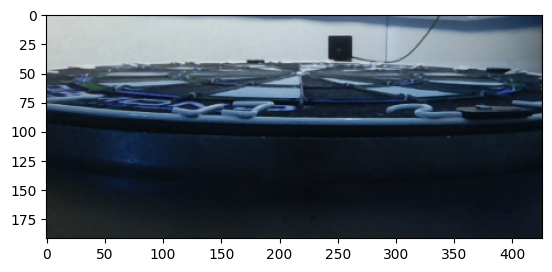

test frame
Readed Frame


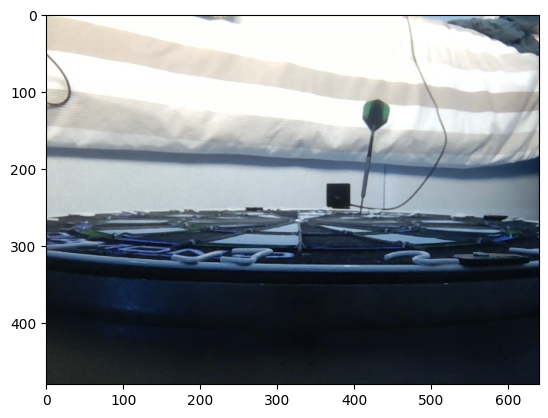

ResizedTestFrame


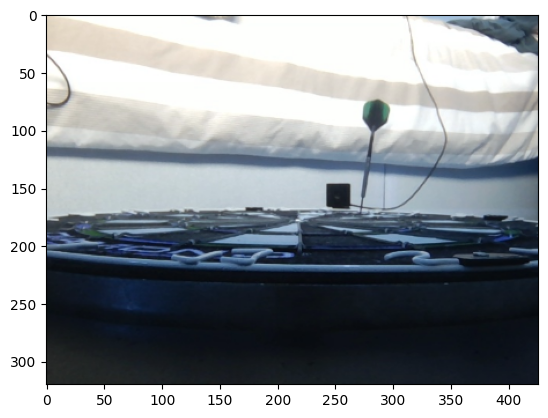

CroppedTestFrame


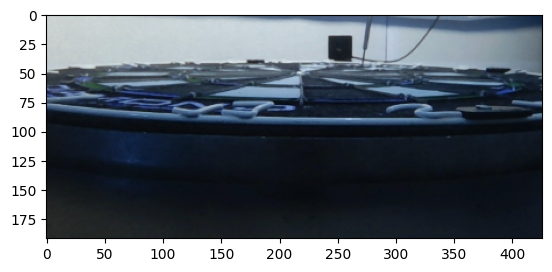

create difference with medianfilterkernelsize: 5
calculating difference


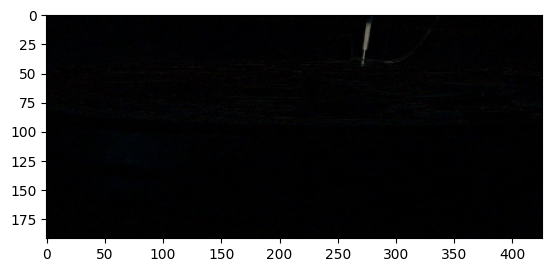


converted img from rgb to gray


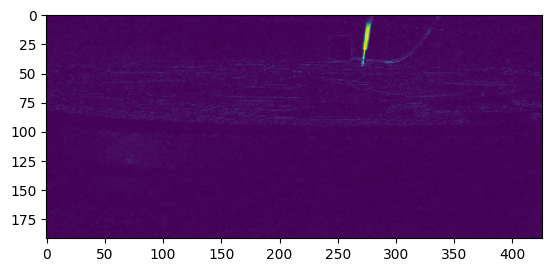


geglättetes Bild mit Kernelgröße: 5


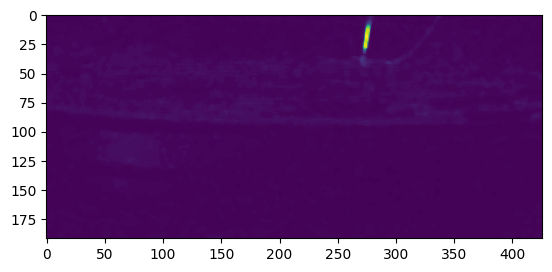


image processing
Canny Algorithm


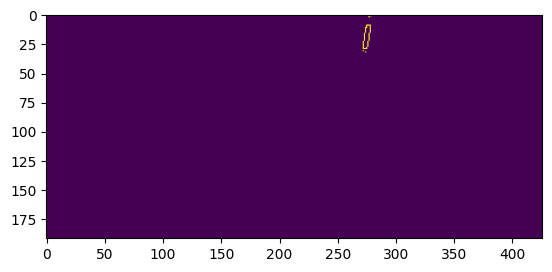


triangle_threshold: 6


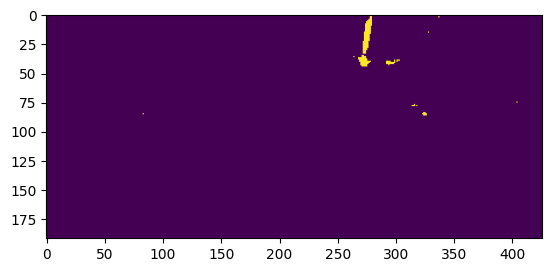


yen_threshold: 13


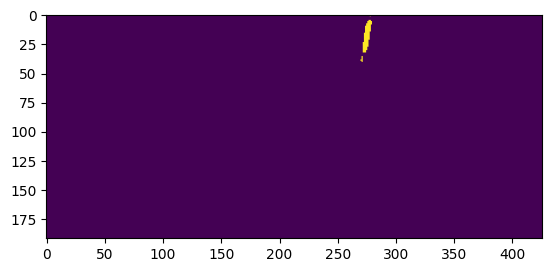


li_threshold: 1.714093356029146


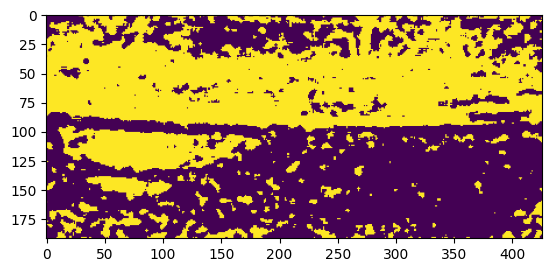


combined_thresh: [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 85. 85.  0.]
 [ 0.  0.  0. ... 85.  0.  0.]
 [ 0.  0.  0. ... 85.  0.  0.]]



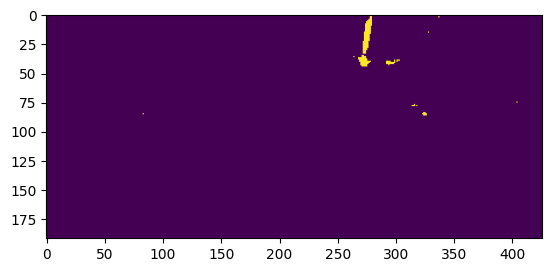


Morphological kernel as ellipse 3x5 operations
KernelOpen:


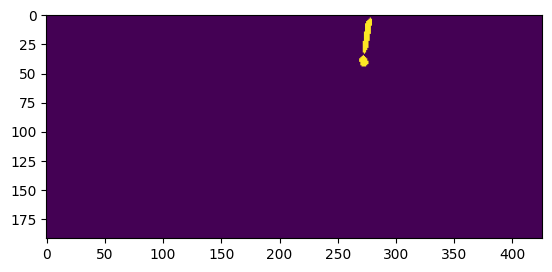

KernelClose:


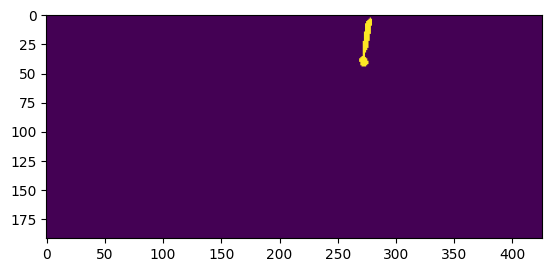

eingegangenes geglättetes Bild


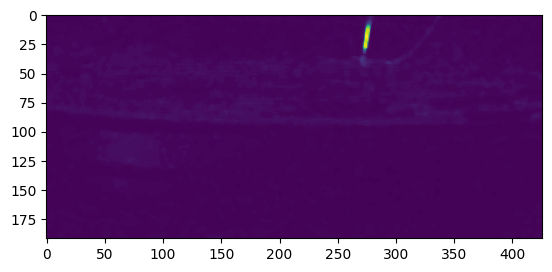

Anwendung threshold..


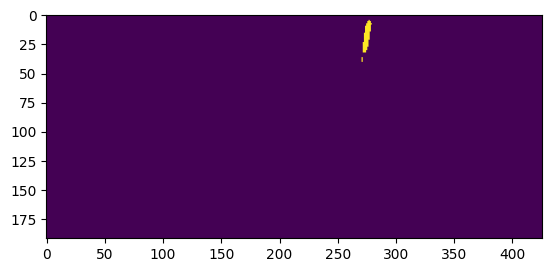


Anwendung Kernel Open


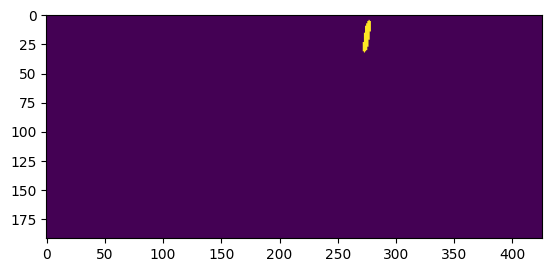


Anwendung Kernel Close


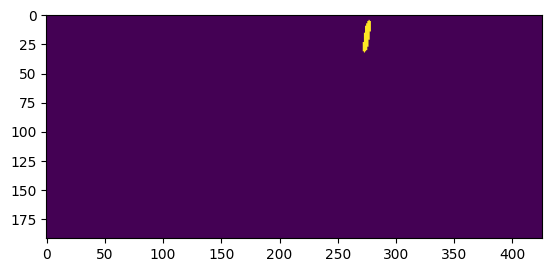


Returns
final


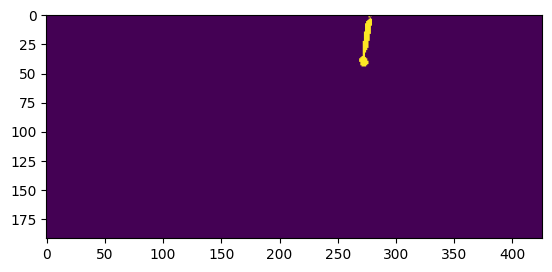

thresh


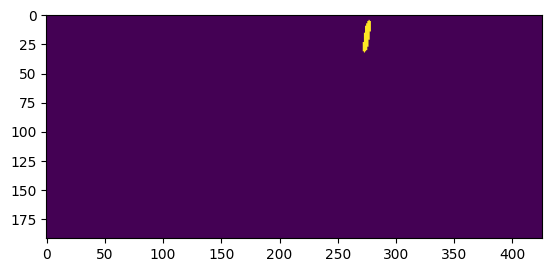

find dart tip Gradient - final image
FindingDartTip:
Anzahl detektierte Konturen = 1

Kontur: 1
mean potential: (np.int64(273), np.int64(43))


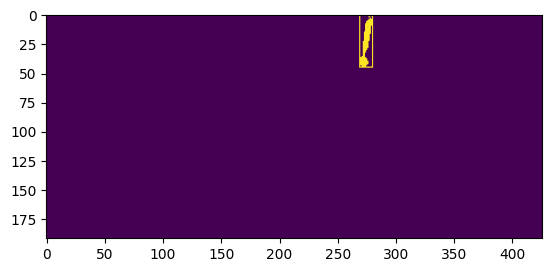

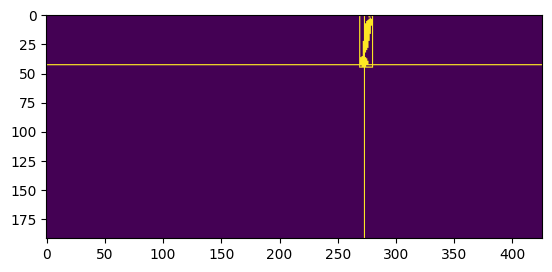

set val to new potential
Result of Find Dart Tip:


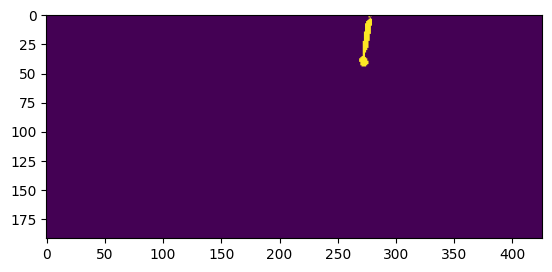

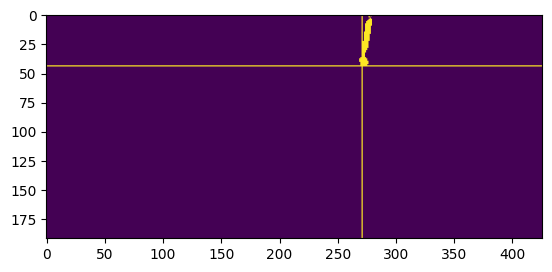

find dart tip Gradient - thresh image
FindingDartTip:
Anzahl detektierte Konturen = 1

Kontur: 1
mean potential: (np.int64(273), np.int64(31))


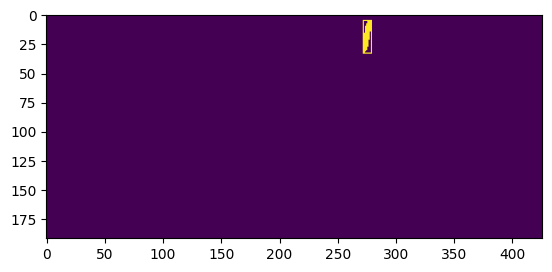

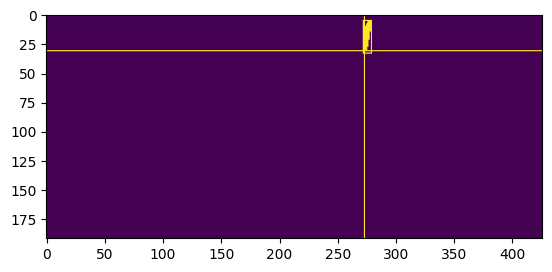

set val to new potential
Result of Find Dart Tip:


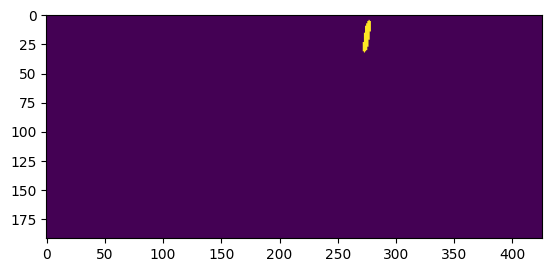

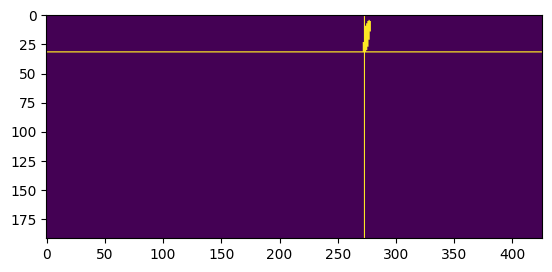

Angle: 10.235808220142946
Angle: 0.0
adjusted Angle 19.235808220142946
Gradient: 2.8658406213279055


In [66]:
cGrad = score_detection(frame_empty_C, frame_d20_C, "C", 5, True)

In [67]:
def intersect(xPos1, yPos1, gradient1, xPos2, yPos2, gradient2):
    yPos1 = -yPos1
    yPos2 = -yPos2

    c1 = yPos1 - (xPos1*gradient1)
    c2 = yPos2 - (xPos2*gradient2)

    x = (c2 - c1) / (gradient1 - gradient2)
    y = gradient1*x + c1

    return (x, y)

In [68]:
class Dart:
    STRING_REP = ('', 'S', 'D', 'T')

    def __init__(self, score, multiplier, position):
        self.score = int(score)
        self.multiplier = int(multiplier)
        self.position = position

    def value(self):
        return self.score * self.multiplier
    
    def is_double(self):
        return self.multiplier == 2

    def to_string(self):
        return self.STRING_REP[self.multiplier] + str(self.score)
    
    def is_bust(self):
        return False
    
    def get_position(self):
        return self.position

In [69]:
def cartesian_to_polar(x, y):
    r = math.sqrt(x**2 + y**2)

    input_num = complex(x, y)
    r, theta = cmath.polar(input_num)
    theta += -math.pi/2
    
    return (r, theta)

In [70]:
def score_dart(x, y):
    r, theta = cartesian_to_polar(x, y)

    print(f"calculated polar: r: {r}, theta: {theta}")

    sectors = [20,5,12,9,14,11,8,16,7,19,3,17,2,15,10,6,13,4,18,1]
    sector = math.floor(((theta)/(2*math.pi))*20 + 1/2)

    print(f"calculated sector: {sector}")

    value = sectors[sector]

    print(f"calculated value: {value}")

    if 170 < r:
        return Dart(0, 0, [x, y])
    elif 162 < r:
        return Dart(value, 2, [x, y])
    elif 107 < r:
        return Dart(value, 1, [x, y])
    elif 99 < r:
        return Dart(value, 3, [x, y])
    elif 16 < r:
        return Dart(value, 1, [x, y])
    elif 6.35 < r:
        return Dart(25, 1, [x, y])
    else:
        return Dart(25, 2, [x, y])

In [71]:
def scoring_points(aGrad, bGrad, cGrad):
    # Camera locations
    aCameraX = -335*math.cos(math.radians(27))
    aCameraY = 335*math.sin(math.radians(27))
    bCameraX = 335*math.cos(math.radians(27))
    bCameraY = 335*math.sin(math.radians(27))
    cCameraX = 335*math.cos(math.radians(81))
    cCameraY = -335*math.sin(math.radians(81))

    points = []

    points.append(intersect(aCameraX, aCameraY, aGrad, bCameraX, bCameraY, bGrad))
    points.append(intersect(aCameraX, aCameraY, aGrad, cCameraX, cCameraY, cGrad))
    points.append(intersect(bCameraX, bCameraY, bGrad, cCameraX, cCameraY, cGrad))

    print(f"points: {points}")

    xAvg = (sum([i[0] for i in points]))/len(points)
    yAvg = (sum([i[1] for i in points]))/len(points)

    print(f"calculated Average points: xAvg:{xAvg}; yAvg:{yAvg}")

    dart_score = score_dart(xAvg, yAvg)

    print(f"Dart Score: {dart_score.to_string()}")


In [72]:
scoring_points(aGrad, bGrad, cGrad)

points: [(-209.73356799786805, -37.753371803633996), (32.79491346851701, 274.67464738690285), (-85.94073829712879, -65.60280664292931)]
calculated Average points: xAvg:-87.62646427549328; yAvg:57.10615631344651
calculated polar: r: 104.5921140924118, theta: 0.9932270390483815
calculated sector: 3
calculated value: 9
Dart Score: T9


In [73]:
def draw_sector(radius, ax):
    from matplotlib.patches import Wedge
    for i in range(0, 20):
        theta1 = 9 + 18*(i-1)
        theta2 = 9 + (18*i)

        if i % 2 == 0:
            sector = Wedge((0,0), radius, theta1, theta2)
        else:
            sector = Wedge((0,0), radius, theta1, theta2)

        ax.add_patch(sector)

In [74]:
def angle_to_gradient(angle):

    if angle == 0:
        slope = 0
    if angle < 0:
        slope = 1
    if angle > 0:
        slope = -1

    angle = abs(angle)

    gradient = math.sin(math.radians(angle)) / math.cos(math.radians(angle))
    gradient *= slope
    
    return gradient

In [75]:
def initDartboard():
    import matplotlib.pyplot as plt
    import math
    from matplotlib.patches import Wedge, Circle
    fig, ax = plt.subplots()
    ax.set_xlim([-350,350])
    ax.set_ylim([350,-350])
    ax.set_box_aspect(1)
    plt.gca().set_aspect('equal')
    foam = plt.Circle((0, 0), 337.5, color='gray')
    board = plt.Circle((0,0), 225.5, color='#282C34')
    outerBull = plt.Circle((0,0), 16)
    innerBull = plt.Circle((0,0), 6.35)
    ax.add_patch(board)
    draw_sector(170, ax) 
    draw_sector(162, ax)
    draw_sector(107, ax)
    draw_sector(99, ax)


    for i in range(0, 20):
        x1 = math.cos((9/180)*math.pi + 2*math.pi/20*i)*16
        y1 = math.sin((9/180)*math.pi + 2*math.pi/20*i)*16

        x2 = math.cos((9/180)*math.pi + 2*math.pi/20*i)*170
        y2 = math.sin((9/180)*math.pi + 2*math.pi/20*i)*170
        
        x1, y1 = [x1, x2], [y1, y2]
        ax.plot(x1, y1, color='grey', linewidth=1)

        circle1 = Circle((0, 0), radius=170, color='grey', fill=False, linewidth=1)
        circle2 = Circle((0, 0), radius=162, color='grey', fill=False, linewidth=1)
        circle3 = Circle((0, 0), radius=107, color='grey', fill=False, linewidth=1)
        circle4 = Circle((0, 0), radius=99, color='grey', fill=False, linewidth=1)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)
        ax.add_patch(circle4)

    ax.add_patch(outerBull)
    ax.add_patch(innerBull)
    circle5 = Circle((0, 0), radius=16, color='grey', fill=False, linewidth=1)
    circle6 = Circle((0, 0), radius=6.35, color='grey', fill=False, linewidth=1)
    ax.add_patch(circle5)
    ax.add_patch(circle6)

    # Camera locations
    aCameraX = -335*math.cos(math.radians(27))
    aCameraY = 335*math.sin(math.radians(27))
    bCameraX = 335*math.cos(math.radians(27))
    bCameraY = 335*math.sin(math.radians(27))
    cCameraX = 335*math.cos(math.radians(81))
    cCameraY = -335*math.sin(math.radians(81))

    ax.plot(-335, 0, color = 'blue', marker=(3, 0, -90), markersize=15)
    ax.plot(aCameraX, aCameraY, color = 'red', marker=(3, 0, -63), markersize=15, )
    ax.plot(bCameraX, bCameraY, color = 'yellow', marker=(3, 0, 63), markersize=15)
    ax.plot(cCameraX, cCameraY, color='#15B01A', marker=(3, 0, 171), markersize=15)

    ax.axline((aCameraX, aCameraY), (aCameraX+10, aCameraY-10*angle_to_gradient(-27)), color='red', linestyle='dashed', linewidth=2)
    ax.axline((bCameraX, bCameraY), (bCameraX+10, bCameraY-10*angle_to_gradient(27)), color='yellow', linestyle='dashed', linewidth=2)
    ax.axline((cCameraX, cCameraY), (cCameraX+10, cCameraY-10*angle_to_gradient(-81)), color='#15B01A', linestyle='dashed', linewidth=2)

    return fig, ax

In [76]:
def showOnDartboard(aGradient, bGradient, cGradient):
    import matplotlib.pyplot as plt
    import math
    from matplotlib.patches import Wedge, Circle

    # Camera locations
    aCameraX = -335*math.cos(math.radians(27))
    aCameraY = 335*math.sin(math.radians(27))
    bCameraX = 335*math.cos(math.radians(27))
    bCameraY = 335*math.sin(math.radians(27))
    cCameraX = 335*math.cos(math.radians(81))
    cCameraY = -335*math.sin(math.radians(81))

    fig, ax = initDartboard()

    ax.axline((aCameraX, aCameraY), (aCameraX + 10, aCameraY - 10 * aGradient), color= 'red', linestyle= 'solid', linewidth = 1.5)
    ax.axline((bCameraX, bCameraY), (bCameraX + 10, bCameraY - 10 * bGradient), color= 'yellow', linestyle= 'solid', linewidth = 1.5)
    ax.axline((cCameraX, cCameraY), (cCameraX + 10, cCameraY - 10 * cGradient), color= '#15B01A', linestyle= 'solid', linewidth = 1.5)

    fig

In [77]:
print(f"aGrad: {aGrad}\nbGrad: {bGrad}\ncGrad: {cGrad}")

aGrad: 1.2882116661165837
bGrad: -0.22496807696067228
cGrad: 2.8658406213279055


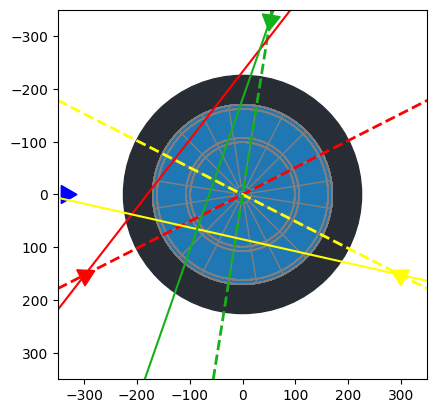

In [78]:
showOnDartboard(aGrad, bGrad, cGrad)